In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Libraries
from scipy.ndimage import zoom
from einops import repeat
from icecream import ic
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import SimpleITK
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.nn.modules.loss import CrossEntropyLoss
from tensorboardX import SummaryWriter
import logging
from tqdm import tqdm
from importlib import import_module

from monai.transforms import (
    Activations,
    AddChanneld, # depricaded, use intead EnsureChannelFirstd(keys=['label'], channel_dim='no_channel')
    AsDiscrete,
    Compose,
    LoadImaged,
    RandFlipd,
    RandRotated,
    RandZoomd,
    ScaleIntensityd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
    RandGaussianNoised,
    RandGaussianSmoothd,
    Rand2DElasticd,
    RandAffined,
    OneOf,
    NormalizeIntensity,
    AsChannelFirstd,
    EnsureType,
    LabelToMaskd
)
from PIL import Image

# extra imports
sys.path.append(str(repo_path / 'SAMed'))
from SAMed.utils import DiceLoss, Focal_loss
from SAMed.segment_anything import build_sam, SamPredictor
from SAMed.segment_anything import sam_model_registry
from SAMed.segment_anything.modeling import Sam

# # for logging in notebook
# import logging
# import sys
# date_strftime_format = "%m/%d/%Y %H:%M:%S"
# logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Transformations

We use the same transformations that in the featus challenge

In [2]:
deform = Rand2DElasticd(
    keys=["image", "label"],
    prob=0.5,
    spacing=(7, 7),
    magnitude_range=(1, 2),
    rotate_range=(np.pi / 6,),
    scale_range=(0.2, 0.2),
    translate_range=(20, 20),
    padding_mode="zeros",
    mode=['bilinear','nearest']
    # device=self.device,
)

affine = RandAffined(
    keys=["image", "label"],
    prob=0.5,
    rotate_range=(np.pi / 6),
    scale_range=(0.2, 0.2),
    translate_range=(20, 20),
    padding_mode="zeros",
    # device=self.device
    mode=['bilinear','nearest']

)

train_transform = Compose(
    [
        EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'), # to add one channel dim to the label (1,256,256)

        ScaleIntensityd(keys=["image"]), # to scale the image intensity to [0,1]

        ## train-specific transforms
        RandRotated(keys=["image", "label"], range_x=(-np.pi / 12, np.pi / 12), prob=0.5, keep_size=True,mode=['bilinear','nearest']),

        RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.5),

        RandZoomd(keys=["image", "label"], min_zoom=0.9, max_zoom=1.1, prob=0.5,mode=['area','nearest']),

        RandGaussianSmoothd(keys=["image"], prob=0.1, sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5)),
        RandGaussianNoised(keys=["image"], mean=0, std=0.1, prob=0.5),

        # TODO check this
        OneOf(transforms=[affine, deform], weights=[0.8, 0.2]), # apply one of the two transforms with the given weights
        ##

        Resized(keys=["image", "label"], spatial_size=(256, 256),mode=['area','nearest']),

        EnsureTyped(keys=["image"] ), # ensure it is a torch tensor or np array
    ]
)

val_transform = Compose(
    [
        EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'),

        ScaleIntensityd(keys=["image"]),

        Resized(keys=["image", "label"], spatial_size=(256, 256),mode=['area','nearest']),
        EnsureTyped(keys=["image"])
    ])

In [3]:
# define paths, get list of images and labels and split them into train and test
experiment_path = repo_path / 'experiments/SAMed_ABUS'
checkpoint_dir = repo_path / 'checkpoints'
root_path = repo_path / 'data/challange_2023/only_lesion'

image_files = np.array([i for i in (root_path / Path("image_mha")).rglob("*.mha")])
label_files = np.array([i for i in (root_path / Path("label_mha")).rglob("*.mha")])

images = [SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(i))) for i in image_files]
labels = [SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(i))) for i in label_files]

idx = 4
sample_list = np.array(list(zip(images,labels)))
im_dic = {"image": sample_list[idx][0], "label": sample_list[idx][1]}

/tmp/ipykernel_3471435/3771519182.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_list = np.array(list(zip(images,labels)))


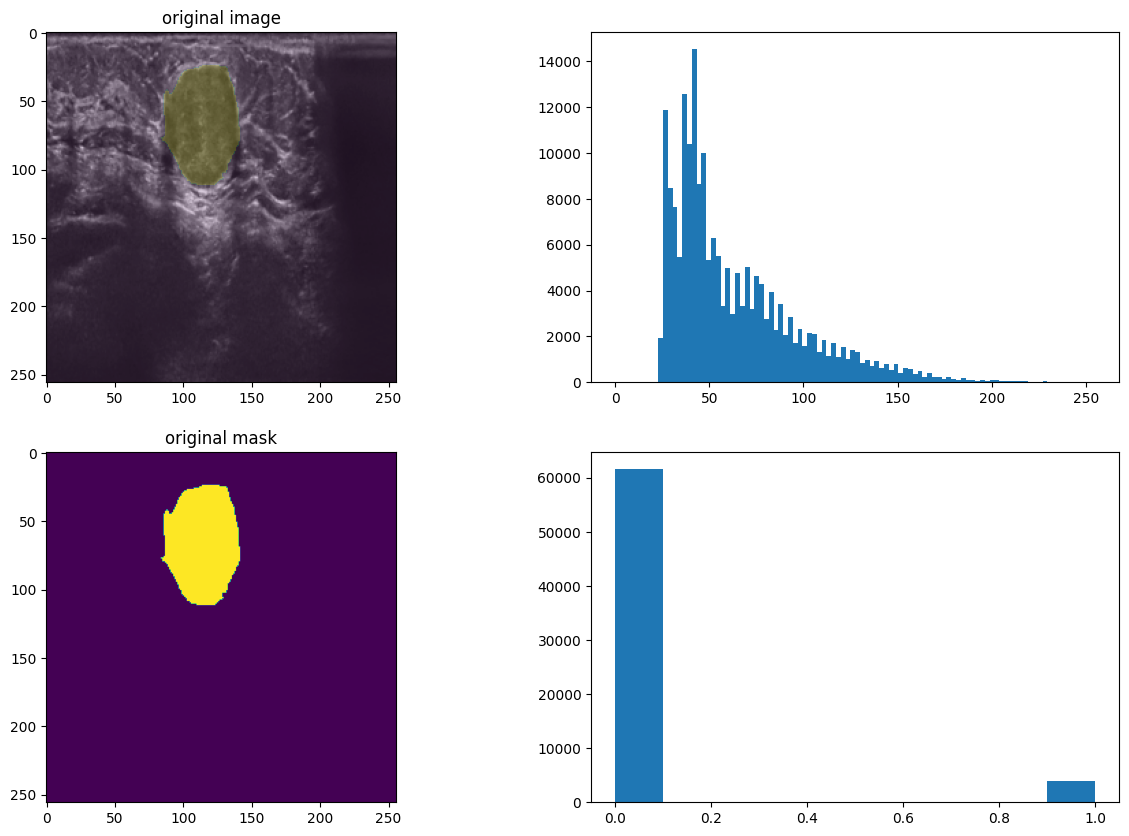

In [4]:
# original image and histograma, move color channel to the end
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax[0,0].imshow(im_dic['image'].transpose(1,2,0))
ax[0,0].title.set_text('original image')
# overlapp mask
ax[0,0].imshow(im_dic['label'],alpha=0.2)
ax[0,1].hist(im_dic['image'].flatten(),bins=100, range=(0,255))
# show mask
ax[1,0].imshow(im_dic['label'])
ax[1,0].title.set_text('original mask')
ax[1,1].hist(im_dic['label'].flatten())
plt.show()

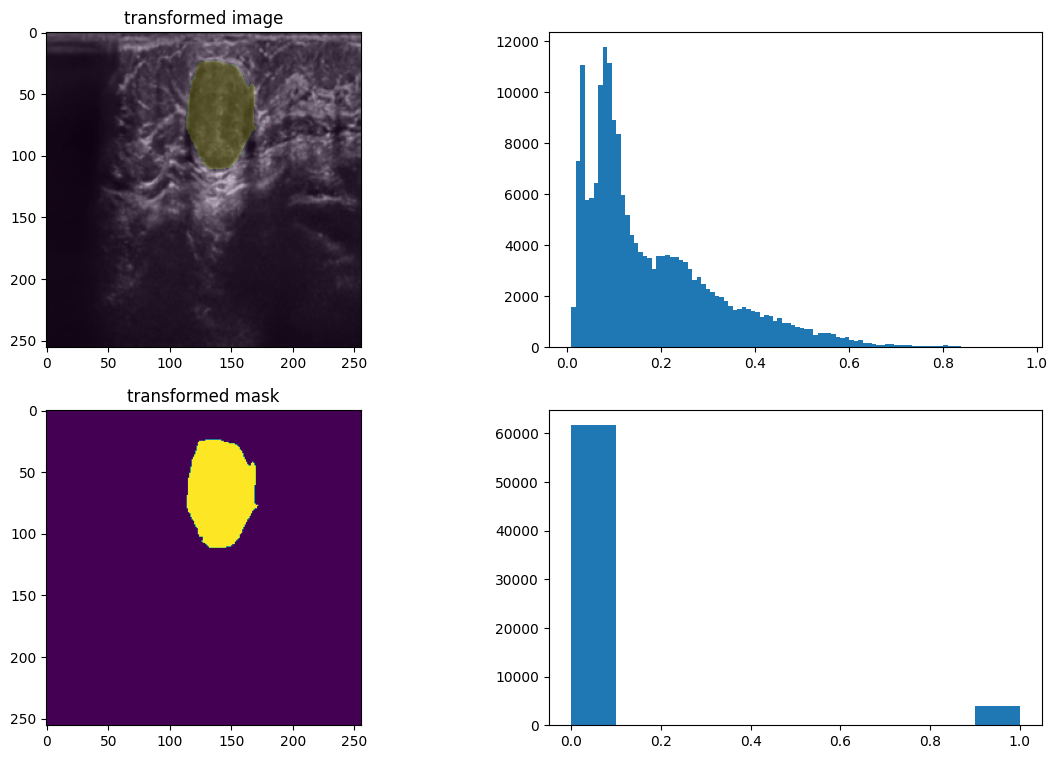

In [5]:
trans = Compose([
    EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'),
    ScaleIntensityd(keys=["image"]),
])
trans_dic = train_transform(im_dic)
trans_image = trans_dic['image']
trans_label = trans_dic['label']

# show transformed image and histograma, move color channel to the end
fig, ax = plt.subplots(2,2,figsize=(14,9))
ax[0,0].imshow(trans_image.permute(1,2,0))
ax[0,0].title.set_text('transformed image')
# overlapp mask
ax[0,0].imshow(trans_label.permute(1,2,0),alpha=0.2)
ax[0,1].hist(trans_image.flatten(),bins=100)
# show mask
ax[1,0].imshow(trans_label.permute(1,2,0))
ax[1,0].title.set_text('transformed mask')
ax[1,1].hist(trans_label.flatten())
plt.show()

# Split

The split is patient wise and just requires a tiny variation

In [6]:
class Fetal_dataset(Dataset):
    
    def __init__(self, list_dir, transform=None):
        self.transform = transform  # using transform in torch!
        images = [SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(i))) for i in list_dir[0]]
        labels = [SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(i))) for i in list_dir[1]]

        self.sample_list = np.array(list(zip(images,labels)))
        
        self.resize=Compose([Resized(keys=["label"], spatial_size=(64, 64),mode=['nearest'])])

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        
        if self.transform:
            sample=self.transform({"image": self.sample_list[idx][0], "label": self.sample_list[idx][1]})
        
        sample['low_res_label']=self.resize({"label":sample['label']})['label'][0]
        sample['label']=sample['label'][0]
        return sample
    
def calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, dice_weight:float=0.8):
    """Compute the loss of the network using a linear combination of cross entropy and dice loss.

    Args:
        outputs (Torch.Tensor): output of the network
        low_res_label_batch (Torch.Tensor): low resolution version of the label (mask)
        ce_loss (functional): CrossEntropyLoss
        dice_loss (functional): Dice loss from SAMed
        dice_weight (float, optional): parametrization the linear combination (high=more importance to dice). Defaults to 0.8.

    Returns:
        float: loss, loss_ce, loss_dice floats
    """
    low_res_logits = outputs['low_res_logits']
    loss_ce = ce_loss(low_res_logits, low_res_label_batch.long())
    loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
    loss = (1 - dice_weight) * loss_ce + dice_weight * loss_dice
    return loss, loss_ce, loss_dice


In [7]:
# we make a split of our 100 ids
kf = KFold(n_splits=5,shuffle=True,random_state=0)
for fold_n, (train_ids, val_ids) in enumerate(kf.split(range(100))):
    print(train_ids, val_ids)
    print(len(train_ids), len(val_ids))
    break

[ 0  1  3  4  5  6  9 10 11 12 14 15 17 18 19 20 21 23 25 27 28 29 31 32
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 74 76 77 79 80 81 82 83 84 85 87 88
 89 90 91 94 96 97 98 99] [ 2  7  8 13 16 22 24 26 30 33 53 54 55 73 75 78 86 92 93 95]
80 20


In [8]:
path_images = (root_path / "image_mha")
path_labels = (root_path / "label_mha")
# get all files in the folder in a list, only mha files
image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
# now, we will check if the path has at least one of the ids in the train_ids list
train_files = [file for file in image_files if any(f'id_{id}_' in file for id in train_ids)]
val_files = [file for file in image_files if any(f'id_{id}_' in file for id in val_ids)]

image_files = np.array([path_images / i for i in train_files])
label_files = np.array([path_labels / i for i in train_files])
list_train = [image_files, label_files]

image_files = np.array([path_images / i for i in val_files])
label_files = np.array([path_labels / i for i in val_files])
list_val = [image_files, label_files]


In [9]:
# HP
base_lr = 0.001
num_classes = 2
batch_size = 16
multimask_output = True
warmup=0
max_epoch = 50
save_interval = 5
iter_num = 0
warmup_period=1000
device=0 # device id

# define datasets, notice that the inder depends on the fold
db_train = Fetal_dataset(transform=train_transform,list_dir=list_train)
db_val = Fetal_dataset(transform=val_transform,list_dir=list_val)

# define dataloaders
trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(db_val, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)


/tmp/ipykernel_3471435/2329267976.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


In [10]:
# take next sampler
batch = next(iter(trainloader))

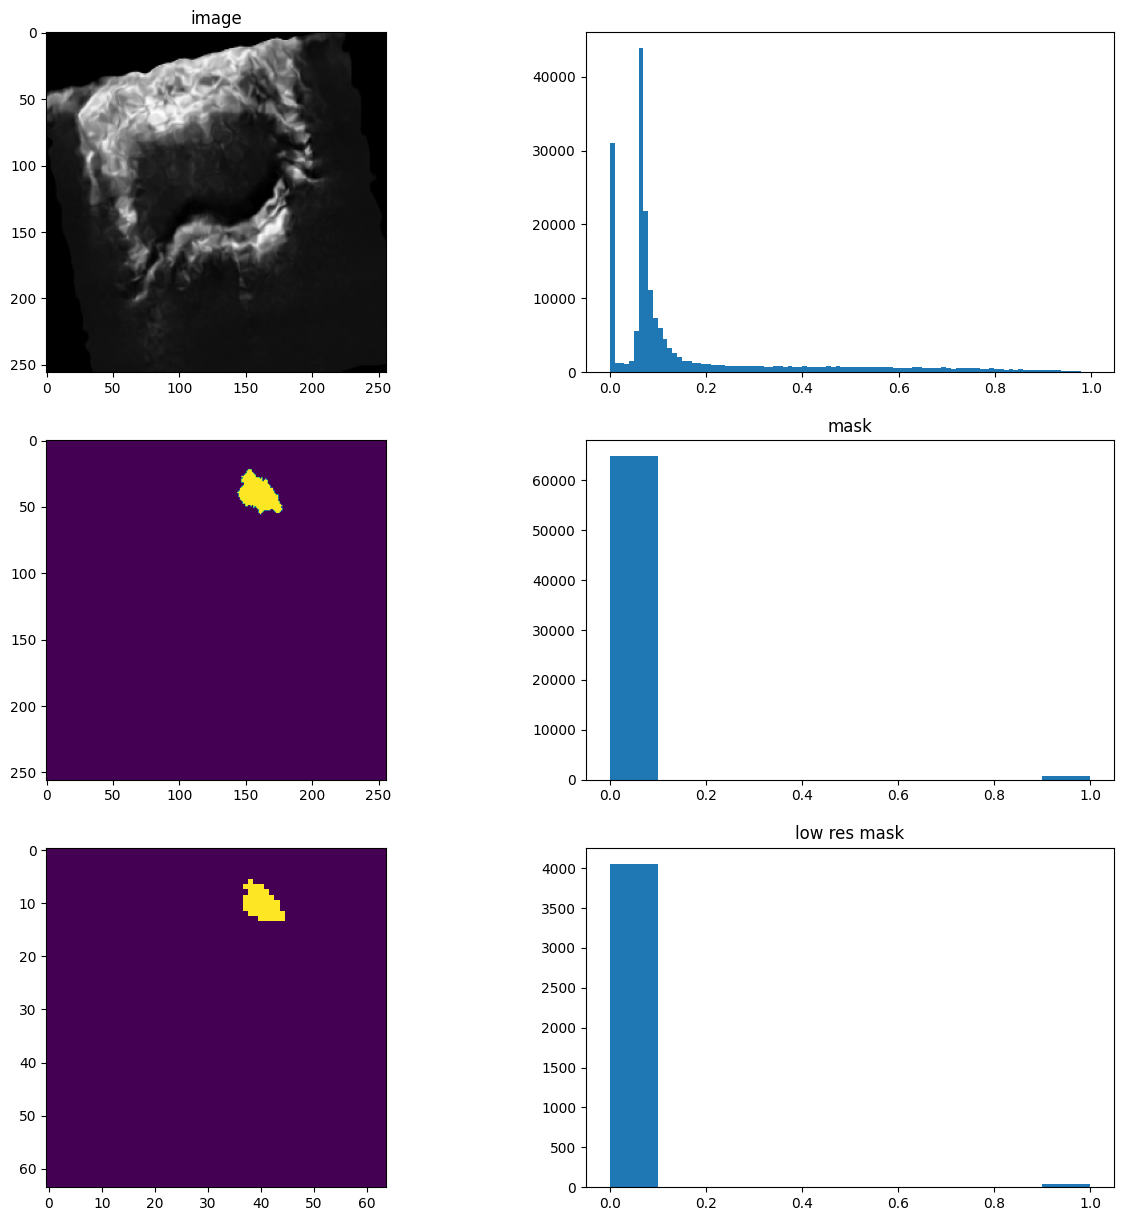

In [11]:
# show image, mask and low res mask, each with histogram
fig, ax = plt.subplots(3,2,figsize=(15,15))
ax[0,0].imshow(batch['image'][0].permute(1,2,0), cmap='gray')
ax[0,0].title.set_text('image')
ax[0,1].hist(batch['image'][0].flatten(),bins=100)
# show mask
ax[1,0].imshow(batch['label'][0])
ax[1,1].title.set_text('mask')
ax[1,1].hist(batch['label'][0].flatten())
# show low res mask
ax[2,0].imshow(batch['low_res_label'][0])
ax[2,1].title.set_text('low res mask')
ax[2,1].hist(batch['low_res_label'][0].flatten())
plt.show()

# Training

In [12]:
# the lora parameters folder is created to save the weights
lora_weights = experiment_path / f'results_load_more/{fold_n}'
os.makedirs(lora_weights,exist_ok=True)

In [13]:
# register SAM model
sam, img_embedding_size = sam_model_registry['vit_b'](image_size=256,
                                                            num_classes=num_classes,
                                                            checkpoint=str(checkpoint_dir / 'sam_vit_b_01ec64.pth'),
                                                            pixel_mean=[0, 0, 0],
                                                            pixel_std=[1, 1, 1])

pkg = import_module('sam_lora_image_encoder')
net = pkg.LoRA_Sam(sam, 4).to(device)
# net.load_lora_parameters(str(checkpoint_dir / 'epoch_159.pth' ))
model=net
print("The length of train set is: {}".format(len(db_train)))

The length of train set is: 2563


INFO:root:161 iterations per epoch. 8050 max iterations 
Training:   0%|                             | 0/50 [00:00<?, ?epoch/s]

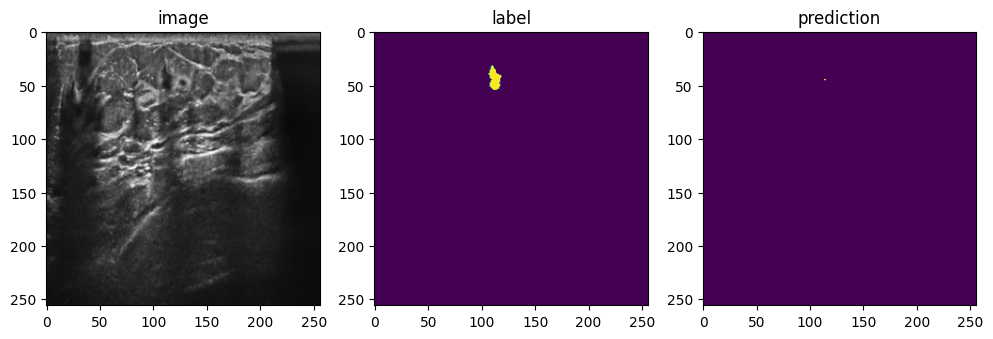

INFO:root:epoch 0 : val loss : 0.124714, val loss_ce: 0.033196, val loss_dice: 0.091518
INFO:root:save model to /home/ricardo/ABUS2023_documents/tdsc_abus23/experiments/SAMed_ABUS/results_load_more/0/epoch_0.pth
Training:   2%|▍                    | 1/50 [01:03<52:03, 63.74s/epoch]

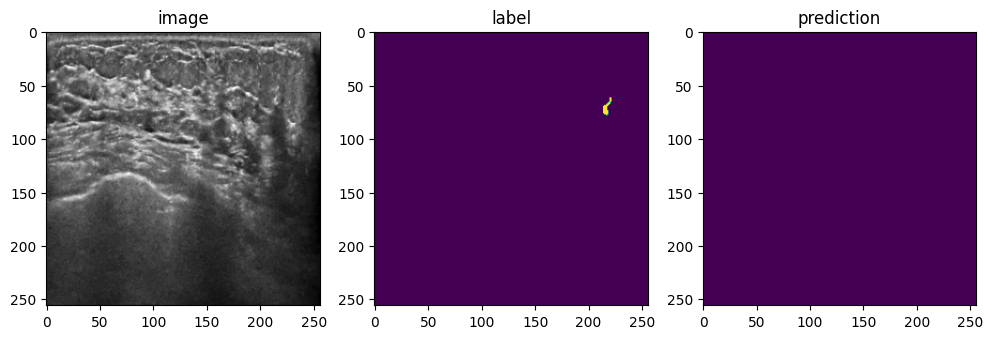

INFO:root:epoch 1 : val loss : 0.133835, val loss_ce: 0.039297, val loss_dice: 0.094538
Training:   4%|▊                    | 2/50 [02:05<49:50, 62.30s/epoch]

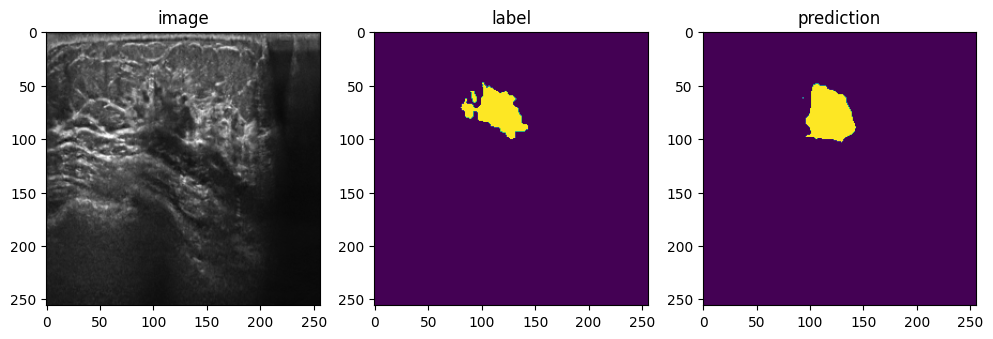

INFO:root:epoch 2 : val loss : 0.124057, val loss_ce: 0.036413, val loss_dice: 0.087644
INFO:root:save model to /home/ricardo/ABUS2023_documents/tdsc_abus23/experiments/SAMed_ABUS/results_load_more/0/epoch_2.pth
Training:   6%|█▎                   | 3/50 [03:07<48:59, 62.53s/epoch]

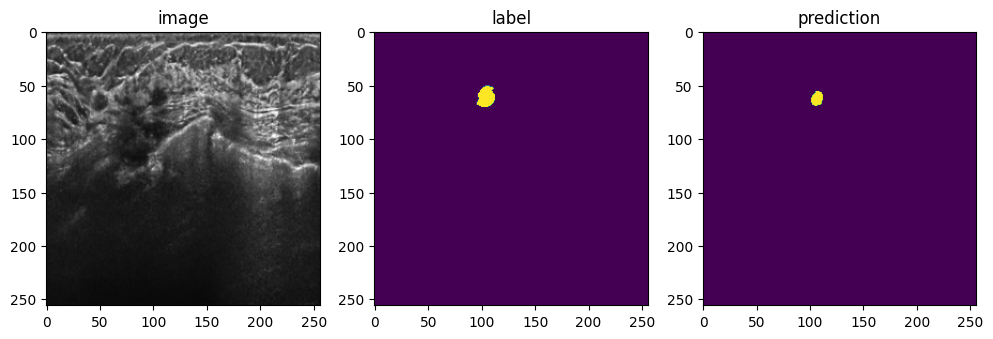

INFO:root:epoch 3 : val loss : 0.107099, val loss_ce: 0.025736, val loss_dice: 0.081362
INFO:root:save model to /home/ricardo/ABUS2023_documents/tdsc_abus23/experiments/SAMed_ABUS/results_load_more/0/epoch_3.pth
Training:   8%|█▋                   | 4/50 [04:10<48:06, 62.74s/epoch]

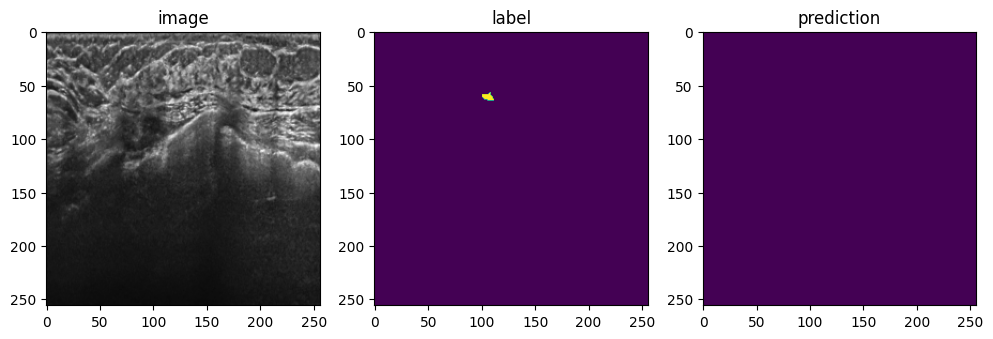

INFO:root:epoch 4 : val loss : 0.105880, val loss_ce: 0.023757, val loss_dice: 0.082123
Training:  10%|██                   | 5/50 [05:15<47:27, 63.27s/epoch]

In [14]:
model.train()
# metrics
ce_loss = CrossEntropyLoss()
dice_loss = DiceLoss(num_classes + 1)
# max iterations
max_iterations = max_epoch * len(trainloader)  

# optimizer
if warmup:
    b_lr = base_lr / warmup_period
else:
    b_lr = base_lr
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True)

# logging
writer = SummaryWriter(experiment_path / f'results/{fold_n}/logs')
logging.basicConfig(level = logging.INFO)
logging.info("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))

# init useful variables
iterator = tqdm(range(max_epoch), ncols=70, desc="Training", unit="epoch")
iter_num = 0
best_performance = 100100

for epoch_num in iterator:
    # lists
    train_loss_ce = []
    train_loss_dice = []
    val_loss_ce = []
    val_loss_dice = []
    val_dice_score=[]
    
    for i_batch, sampled_batch in enumerate(trainloader):
        # load batches
        image_batch, label_batch = sampled_batch['image'], sampled_batch['label']  # [b, c, h, w], [b, h, w]
        low_res_label_batch = sampled_batch['low_res_label'] # for logging
        # send to device (gpu)
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        low_res_label_batch = low_res_label_batch.to(device)
        
        assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}' #check the intensity range of the image
        
        # forward and loss computing
        outputs = model(batched_input = image_batch, multimask_output = multimask_output, image_size = 256)
        loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, 0.8)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if warmup and iter_num < warmup_period: # if in warmup period, adjust learning rate
            lr_ = base_lr * ((iter_num + 1) / warmup_period)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
        else: # if not in warmup period, adjust learning rate
            if warmup:
                shift_iter = iter_num - warmup_period
                assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
            else: # if not warm up at all, leave the shift as the iter number
                shift_iter = iter_num
            lr_ = base_lr * (1.0 - shift_iter / max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

        # logging
        writer.add_scalar('info/lr', lr_, iter_num) # log the learning rate
        # append lists
        train_loss_ce.append(loss_ce.detach().cpu().numpy())
        train_loss_dice.append(loss_dice.detach().cpu().numpy())
        # show to user
        #print(f'iteration {iter_num} : loss : {loss.item()}, loss_ce: {loss_ce.item()}, loss_dice: {loss_dice.item()} ,lr:{optimizer.param_groups[0]["lr"]}')
        # update the iter number
        iter_num += 1 

    # train logging after each epoch
    train_loss_ce_mean = np.mean(train_loss_ce)
    train_loss_dice_mean = np.mean(train_loss_dice)
    writer.add_scalar('info/total_loss', train_loss_ce_mean+train_loss_dice_mean, iter_num)
    writer.add_scalar('info/loss_ce', train_loss_ce_mean, iter_num)
    writer.add_scalar('info/loss_dice', train_loss_dice_mean, iter_num)
    
    # validation after each epoch
    model.eval()
    for i_batch, sampled_batch in enumerate(valloader):
        image_batch, label_batch = sampled_batch["image"].to(device), sampled_batch["label"].to(device)
        low_res_label_batch = sampled_batch['low_res_label'].to(device)
        
        assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}'
        
        # forward and losses computing
        outputs = model(image_batch, multimask_output, 256)
        loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, 0.8)
        # append lists
        val_loss_ce.append(loss_ce.detach().cpu().numpy())
        val_loss_dice.append(loss_dice.detach().cpu().numpy())
        
        # at the very end of the epoch, for the last batch, show the images
        if i_batch % 100 == 0:            
            fig,ax = plt.subplots(1,3,figsize=(12,6))
            ax[0].imshow(sampled_batch['image'][0].cpu().numpy().transpose(1,2,0)) 
            ax[0].set_title('image') 
            ax[1].imshow(sampled_batch['label'][0]) 
            ax[1].set_title('label')
            output_masks = outputs['masks']
            output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

            ax[2].imshow(output_masks[0].cpu()[0]) 
            ax[2].set_title('prediction') 
            plt.show()
            plt.close()


    # validation logging after each epoch
    val_loss_ce_mean = np.mean(val_loss_ce)
    val_loss_dice_mean = np.mean(val_loss_dice)
    writer.add_scalar('info/val_total_loss', val_loss_ce_mean+val_loss_dice_mean, iter_num)
    writer.add_scalar('info/val_loss_ce', val_loss_ce_mean, iter_num)
    writer.add_scalar('info/val_loss_dice', val_loss_dice_mean, iter_num)
    # show to user
    logging.info('epoch %d : val loss : %f, val loss_ce: %f, val loss_dice: %f' % (epoch_num, val_loss_ce_mean+val_loss_dice_mean,
                                                                        val_loss_ce_mean, val_loss_dice_mean))

    # update learning rate
    scheduler.step(val_loss_ce_mean+val_loss_dice_mean)
    
    # saving model
    if val_loss_dice_mean < best_performance: # if dice is better, save model
        best_performance=val_loss_dice_mean
        save_mode_path = os.path.join(lora_weights, 'epoch_' + str(epoch_num) + '.pth')
        try:
            model.save_lora_parameters(save_mode_path)
        except:
            model.module.save_lora_parameters(save_mode_path)
        logging.info("save model to {}".format(save_mode_path))

    if epoch_num >= max_epoch - 1: # save model at the last epoch
        save_mode_path = os.path.join(lora_weights, 'epoch_' + str(epoch_num) + '.pth')
        try:
            model.save_lora_parameters(save_mode_path)
        except:
            model.module.save_lora_parameters(save_mode_path)
        logging.info("save model to {}".format(save_mode_path))
        iterator.close()
    model.train()
    
writer.close()


# Inference